# Cubic Fit Analysis: Is Layer 35 Response Nonlinear?

**Observation:** The data from -10 to +10 looks like it might be cubic — flattish in the middle around α ≈ -1, curving upward on both ends.

**Question:** Does a cubic polynomial fit the data better than a linear model?

**Data source:** `../data/results/steering_deep_space_layer35.csv`

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data
df = pd.read_csv('../data/results/steering_deep_space_layer35.csv')

# Use full range
ALPHA_MIN = -10.0
ALPHA_MAX = 10.0

mask = (df['alpha'] >= ALPHA_MIN) & (df['alpha'] <= ALPHA_MAX)
df_range = df[mask].copy()

print(f"✓ Loaded {len(df_range)} samples")
print(f"  α range: [{df_range['alpha'].min():.2f}, {df_range['alpha'].max():.2f}]")
print(f"  Grade level range: [{df_range['grade_level'].min():.1f}, {df_range['grade_level'].max():.1f}]")

✓ Loaded 1000 samples
  α range: [-10.00, 10.00]
  Grade level range: [5.6, 38.0]


## Fit Linear Model

In [2]:
# Linear fit
slope, intercept, r_value, p_value, std_err = linregress(
    df_range['alpha'], df_range['grade_level']
)
r_squared_linear = r_value ** 2

df_range['predicted_linear'] = intercept + slope * df_range['alpha']
df_range['residual_linear'] = df_range['grade_level'] - df_range['predicted_linear']
rmse_linear = np.sqrt(np.mean(df_range['residual_linear']**2))

print(f"Linear model: y = {intercept:.2f} + {slope:.3f}α")
print(f"R² = {r_squared_linear:.4f}")
print(f"RMSE = {rmse_linear:.3f}")

Linear model: y = 11.22 + 0.581α
R² = 0.6898
RMSE = 2.250


## Fit Cubic Model

Fit: y = a + b·α + c·α² + d·α³

In [3]:
# Cubic fit: y = a + b*x + c*x² + d*x³
# np.polyfit returns coefficients in descending order: [d, c, b, a]
coeffs = np.polyfit(df_range['alpha'], df_range['grade_level'], deg=3)
cubic_poly = np.poly1d(coeffs)

df_range['predicted_cubic'] = cubic_poly(df_range['alpha'])
df_range['residual_cubic'] = df_range['grade_level'] - df_range['predicted_cubic']

# R² for cubic
ss_res = np.sum(df_range['residual_cubic']**2)
ss_tot = np.sum((df_range['grade_level'] - df_range['grade_level'].mean())**2)
r_squared_cubic = 1 - (ss_res / ss_tot)
rmse_cubic = np.sqrt(np.mean(df_range['residual_cubic']**2))

d, c, b, a = coeffs
print(f"Cubic model: y = {a:.2f} + {b:.3f}α + {c:.4f}α² + {d:.5f}α³")
print(f"R² = {r_squared_cubic:.4f}")
print(f"RMSE = {rmse_cubic:.3f}")

# Find inflection point (where curvature changes sign)
# For cubic y = a + bx + cx² + dx³, second derivative y'' = 2c + 6dx
# Inflection where y'' = 0, so x = -c/(3d)
if abs(d) > 1e-10:
    inflection_alpha = -c / (3 * d)
    inflection_grade = cubic_poly(inflection_alpha)
    print(f"\nInflection point: α = {inflection_alpha:.2f}, grade = {inflection_grade:.1f}")

Cubic model: y = 9.88 + 0.121α + 0.0401α² + 0.00765α³
R² = 0.8604
RMSE = 1.510

Inflection point: α = -1.75, grade = 9.8


## Comparison

In [4]:
print(f"{'='*70}")
print(f"LINEAR vs CUBIC")
print(f"{'='*70}")
print(f"Model      R²        RMSE      Improvement")
print(f"Linear:   {r_squared_linear:.4f}    {rmse_linear:.3f}     (baseline)")
print(f"Cubic:    {r_squared_cubic:.4f}    {rmse_cubic:.3f}     ΔR² = {r_squared_cubic - r_squared_linear:+.4f}")
print(f"                             ΔRMSE = {rmse_cubic - rmse_linear:+.3f}")

LINEAR vs CUBIC
Model      R²        RMSE      Improvement
Linear:   0.6898    2.250     (baseline)
Cubic:    0.8604    1.510     ΔR² = +0.1705
                             ΔRMSE = -0.740


## Visualization

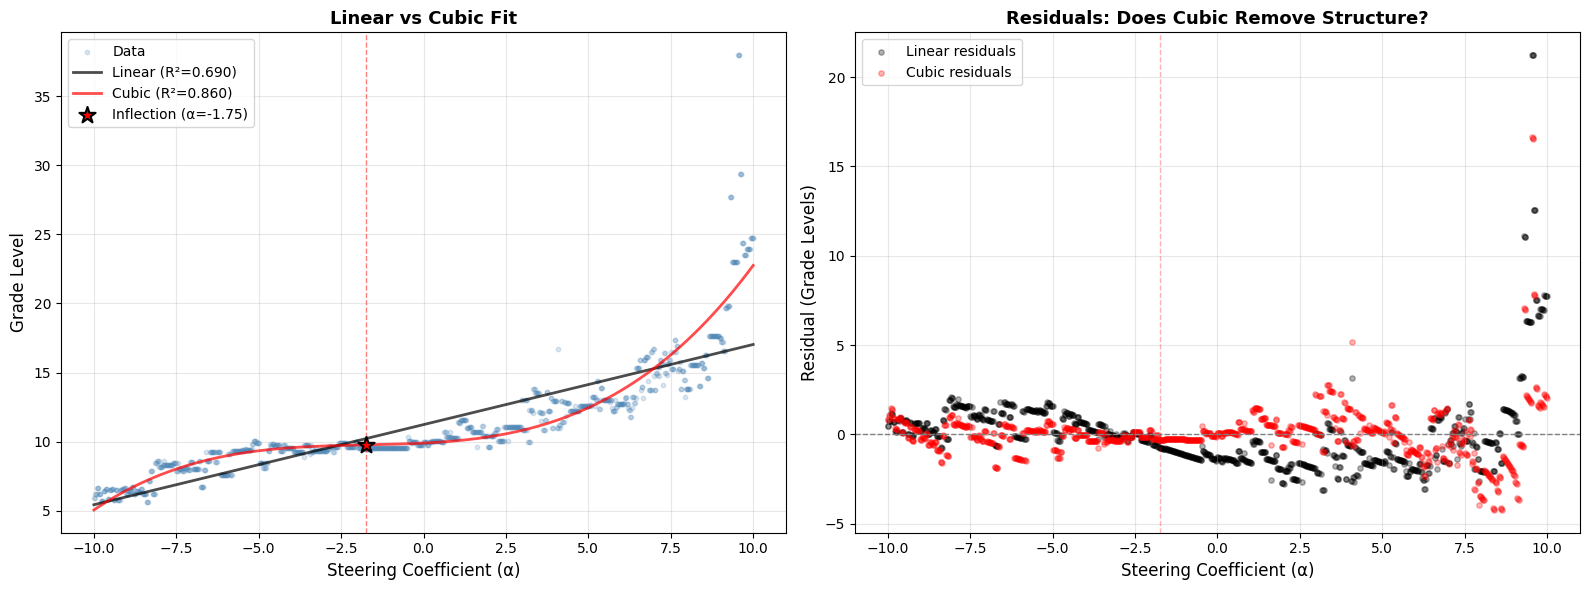

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Data with both fits
ax1.scatter(df_range['alpha'], df_range['grade_level'], alpha=0.2, s=10, 
           color='steelblue', label='Data')

# Linear fit
alpha_sorted = np.sort(df_range['alpha'])
ax1.plot(alpha_sorted, intercept + slope * alpha_sorted, 
        'k-', linewidth=2, label=f'Linear (R²={r_squared_linear:.3f})', alpha=0.7)

# Cubic fit (smooth)
alpha_smooth = np.linspace(ALPHA_MIN, ALPHA_MAX, 200)
ax1.plot(alpha_smooth, cubic_poly(alpha_smooth), 
        'r-', linewidth=2, label=f'Cubic (R²={r_squared_cubic:.3f})', alpha=0.7)

# Mark inflection point if it exists and is in range
if 'inflection_alpha' in locals() and ALPHA_MIN <= inflection_alpha <= ALPHA_MAX:
    ax1.axvline(inflection_alpha, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.scatter([inflection_alpha], [inflection_grade], 
               color='red', s=150, marker='*', zorder=10, 
               edgecolors='black', linewidths=1.5,
               label=f'Inflection (α={inflection_alpha:.2f})')

ax1.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax1.set_ylabel('Grade Level', fontsize=12)
ax1.set_title('Linear vs Cubic Fit', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Residuals
ax2.scatter(df_range['alpha'], df_range['residual_linear'], 
           alpha=0.3, s=15, color='black', label='Linear residuals')
ax2.scatter(df_range['alpha'], df_range['residual_cubic'], 
           alpha=0.3, s=15, color='red', label='Cubic residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

if 'inflection_alpha' in locals():
    ax2.axvline(inflection_alpha, color='red', linestyle='--', alpha=0.3, linewidth=1)

ax2.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax2.set_ylabel('Residual (Grade Levels)', fontsize=12)
ax2.set_title('Residuals: Does Cubic Remove Structure?', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()